<a href="https://colab.research.google.com/github/BoasAndreasen/RecommenderSystems/blob/main/MovieLens_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import math
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preparation

In [ ]:
# Data Citation:
# F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on 
# Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. 

! curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2226k      0 --:--:-- --:--:-- --:--:-- 2226k


In [ ]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
# import the dataset
df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [ ]:
# create convertable continous unique values starting from 0
users = df.userId.unique()
movies = df.movieId.unique()

movieId_to_i = {}
i_to_movieId = {}
userId_to_i = {}
i_to_userId = {}

for (i, movieId) in enumerate(movies):
    movieId_to_i[movieId] = i
    i_to_movieId[i] = movieId

for (i, userId) in enumerate(users):
    userId_to_i[userId] = i
    i_to_userId[i] = userId

In [ ]:
# Create 9724 movieId x 610 ratings userId matrix
data = df.pivot_table(index='movieId', columns='userId', values='rating')

# create continous rows and column 0
data1 = data.reset_index(drop=True)

# Make userId start from 0
data2 = data1.rename(columns=dict(zip(data1.columns, list(range(len(data1.columns))))))

print(data2)

userId  0    1    2    3    4    5    6    7    8    9    ...  600  601  602  \
0       4.0  NaN  NaN  NaN  4.0  NaN  4.5  NaN  NaN  NaN  ...  4.0  NaN  4.0   
1       NaN  NaN  NaN  NaN  NaN  4.0  NaN  4.0  NaN  NaN  ...  NaN  4.0  NaN   
2       4.0  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3       NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4       NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9719    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
9720    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
9721    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
9722    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
9723    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

userId  603  604  605  606  607  608  6

In [ ]:
train = data2.copy()

# Set test set to empty array of size 9724 x 610 
test = pd.DataFrame(np.empty(train.shape))
test[:] = np.nan

# Move 20 percent of ratings for each user from train set to test set
for idx, column in data2.iteritems():
    not_null_column = column[column.notna()]
    num_to_replace = int(round(len(not_null_column) * 0.2))
    replace_indices = np.random.choice(not_null_column.index, size=num_to_replace, replace=False)

    for ind in replace_indices:
        test.iloc[ind,idx] = train.iloc[ind,idx]
        train.iloc[ind,idx] = float("nan")

In [ ]:
print("user 52's", data2[52].count(), 'ratings were split into', train[52].count(), 'training and', test[52].count(), 'testing')
print("train set shape:", train.shape)
print("train set number of ratings:", np.count_nonzero(~np.isnan(train)))
print("test set shape:", test.shape)
print("test set number of ratings:", np.count_nonzero(~np.isnan(test)))

user 52's 20 ratings were split into 16 training and 4 testing
train set shape: (9724, 610)
train set number of ratings: 80672
test set shape: (9724, 610)
test set number of ratings: 20164


In [ ]:
# For imputation, fill each movie its average rating
train_imputed = train.T.fillna(train.mean(axis=1)).T
# Since some movies have no ratings in their training set after the split, 
# fill those movies with overall average
train_imputed = train_imputed.fillna(np.nanmean(train.values))

# alternatively fill all values with the overall average
# train_mean = np.nanmean(train.values) #approx 3.5
# train_data = train.fillna(train_mean)

## Median value baseline 

In [ ]:
predicted = np.nanmean(train)
print("Median rating:", "{:.3f}".format(predicted))

diffs = predicted - test
rmse = np.sqrt(np.nanmean(np.square(diffs)))
print("RMSE using median:", "{:.3f}".format(rmse))

Median rating: 3.502
RMSE using median: 1.048


## Eigendecomposition SVD 

In [ ]:
# inspired by https://github.com/amoghasubramanya/Movie-Recommender-using-SVD/blob/master/svd.py
# and https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm

A = np.array(train_imputed)

import time
start_time = time.perf_counter()

# calculate U and sigma
AAT = np.dot(A, np.transpose(A)) #9724 x 9724
eigenvalueAAT, eigenvecAAT = np.linalg.eig(AAT)

# sorted indexes
sorted_eigen_indexes = eigenvalueAAT.argsort()[::-1]
# get real first k sorted eigen values
sigma = np.real(np.sqrt(eigenvalueAAT[sorted_eigen_indexes]))
# get real values sorted by eigenvectors
U = np.real(eigenvecAAT[:,sorted_eigen_indexes])

# calculate V
ATA = np.dot(np.transpose(A), A) #9724 x 9724
eigenvalueATA, eigenvecATA = np.linalg.eig(ATA)
# sort eigen values
sorted_eigen_indexesATA = eigenvalueATA.argsort()[::-1]
# get real values sorted by eigenvectors 
V = np.real(eigenvecATA[:,sorted_eigen_indexesATA])

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 602.6036770259998 seconds


In [ ]:
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 610]

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 50, 100, 250, 610]
k_performance = []

best_k = 0
rmse_at_best_k = 100

for k in k_list:
    U_k = U[:,0:k]
    sigma_k = np.diag(sigma[:k])
    VT_k = np.transpose(V[:,0:k])
    predicted = U_k @ sigma_k @ VT_k

    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))

    k_performance.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

# Re-run
print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
print(k_performance)

The lowest RMSE was 7.141 and was achieved at k: 1
[7.140743409898033, 7.14150589218039, 7.143552314288311, 7.145606148115893, 7.148520294561754, 7.148658387712769, 7.149867612178621, 7.151432663448593, 7.152059495811399, 7.152489829019307, 7.153108298824802, 7.153616896577829, 7.154703536872254, 7.155227637370468, 7.1561464224095435, 7.156355036386312, 7.156548578904705, 7.157228550424164, 7.156816191414842, 7.156519272962333, 7.156673672297748, 7.156436114578581, 7.156286607002416, 7.156046714860786, 7.156187185687782, 7.1567019387063775, 7.155693867983327, 7.156122232065261, 7.156254162502065, 7.156541802347858, 7.157931003065503, 7.159938220193024, 7.159507961691908, 7.160210704309549]


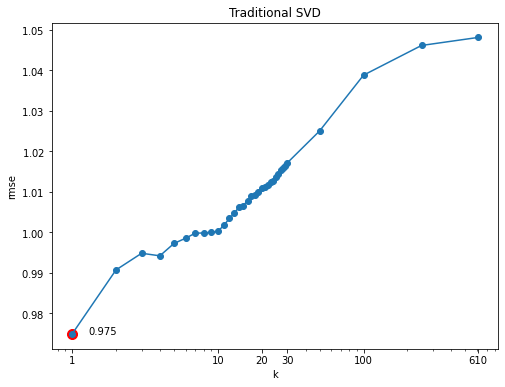

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(k_list, k_performance, marker='o')
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('Traditional SVD')

# Set the x-axis tick locations and labels
x_ticks = [1, 10, 20, 30, 100, 610]
x_tick_labels = ['1', '10', '20', '30', '100', '610']
plt.xticks(x_ticks, x_tick_labels)

# Set the y-axis tick format to use plain numbers
formatter = ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)

# Find the index of the lowest value in performance
min_index = np.argmin(k_performance)

# Plot a scatter marker at the lowest point
plt.scatter(k_list[min_index], k_performance[min_index], s=100, marker='o', color='red')
plt.text(k_list[min_index]+0.3, k_performance[min_index], f'{k_performance[min_index]:.3f}')

plt.show()

## Numpy SVD

In [ ]:
# Numpy SVD
import time
start_time = time.perf_counter()

U, sigma, VT = np.linalg.svd(np.array(train_imputed),full_matrices=False)
predicted = U @ np.diag(sigma) @ VT

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

diffs = predicted - test
mask = ~(np.isnan(diffs) | np.isnan(test))
squared_diffs = np.square(diffs[mask])

# compute mean of squared differences
rmse = np.sqrt(np.nanmean(squared_diffs))
print(rmse)

Execution time: 3.0504139799995755 seconds
0.9811187477544974


In [ ]:
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 50, 100, 250, 610]
k_performance = []

best_k = 0
rmse_at_best_k = 100

for k in k_list:
    U_k = U[:,0:k]
    sigma_k = np.diag(sigma[:k])
    VT_k = VT[:,0:k]
    
    predicted = U_k @ sigma_k @ np.transpose(VT_k)

    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))

    k_performance.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

# Re-run
print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
print(k_performance)

The lowest RMSE was 5.421272681757275 and was achieved at k: 1
[5.421272681757275, 5.421422180968024, 5.4224542694484, 5.421850362125395, 5.421958951957305, 5.422184951274923, 5.421792530719359, 5.421839982047641, 5.422042500111756, 5.422147947305877, 5.422396206977733, 5.422454579625713, 5.422510843982366, 5.422567325953805, 5.422692611566212, 5.422629582365302, 5.422533273373481, 5.422658001793261, 5.422273090554982, 5.422378454937849, 5.421773177571767, 5.421869912793793, 5.421932247865416, 5.421982740089123, 5.421985190123949, 5.422237675362425, 5.422145233585401, 5.422390109034041, 5.422560231011175, 5.4225926395373705, 5.42209295243035, 5.424274974308773, 5.425985684038899, 5.426408075166635]


In [ ]:
from sklearn.utils.extmath import randomized_svd
import time

k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 50, 100, 250, 610]
k_performance = []

best_k = 0
rmse_at_best_k = 100
time_at_best_rmse = 0

for k in k_list:
    start_time = time.perf_counter()
    U, Sigma, VT = randomized_svd(np.array(train_imputed), 
                                  n_components=k,
                                  n_iter=5,
                                  random_state=None)
    
    predicted = U @ np.diag(Sigma) @ VT

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    

    # compute squared differences between non-NaN values
    diffs = predicted - test
    mask = ~(np.isnan(diffs) | np.isnan(test))
    squared_diffs = np.square(diffs[mask])

    # compute mean of squared differences
    rmse = np.sqrt(np.nanmean(squared_diffs))
    k_performance.append(rmse)

    if rmse_at_best_k > rmse:
        best_k = k
        rmse_at_best_k = rmse
        time_at_best_rmse = execution_time

print("The lowest RMSE was", rmse_at_best_k, "and was achieved at k:", best_k)
print("Execution time at best k:", time_at_best_rmse, "seconds")

The lowest RMSE was 0.9571325855990267 and was achieved at k: 15
Execution time at best k: 0.5253192339996531 seconds


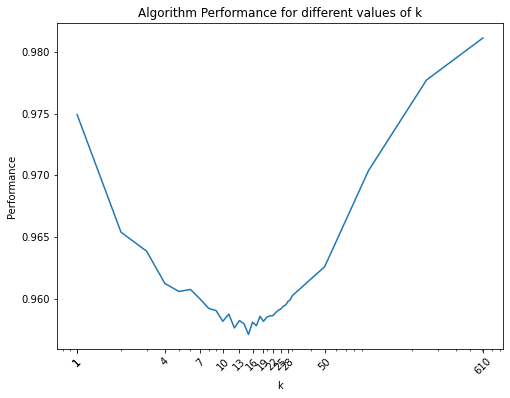

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # adjust the size of the figure

plt.plot(k_list, k_performance)
plt.xscale('log')
plt.xticks([1]+k_list[::3], [1]+k_list[::3], rotation=45) # rotate the tick labels
plt.xlabel('k')
plt.ylabel('Performance')
plt.title('Algorithm Performance for different values of k')
plt.show()

In [ ]:
# Compute the explained variance ratio for each factor
explained_var_ratio = (sigma ** 2) / np.sum(sigma ** 2)

print(explained_var_ratio[0] / sum(explained_var_ratio) * 100, '%')

# Print the explained variance ratio for each factor
print('Explained variance ratio:', explained_var_ratio[:5])

99.91152710070433 %
Explained variance ratio: [9.99115271e-01 2.61257807e-05 1.71713547e-05 1.66040170e-05
 1.47913954e-05]


In [ ]:
# compute squared differences between non-NaN values
diffs = predicted - test
mask = ~(np.isnan(diffs) | np.isnan(test))
squared_diffs = np.square(diffs[mask])

# compute mean of squared differences
rmse = np.sqrt(np.nanmean(squared_diffs))
print(k, rmse)

0.9875777532134082


## Deep Learning

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.LongTensor(ratings['userId'].values)
        self.movie_ids = torch.LongTensor(ratings['movieId'].values)
        self.ratings = torch.FloatTensor(ratings['rating'].values)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)

        self.user_embed.weight.data.uniform_(0,0.05)
        self.movie_embed.weight.data.uniform_(0,0.05)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(embedding_size * 2, embedding_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_size * 2, embedding_size),
            nn.ReLU(),
            nn.Linear(embedding_size, 1)
        )

        self.out = nn.Sigmoid()
        
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        linear_input = self.linear_layers(torch.cat([user_embeds, movie_embeds], dim=1))

        return linear_input
        #return self.out(linear_input) * 5 + 1

mf = MatrixFactorization(609,9723,100)
print(mf)
num_params = sum(p.numel() for p in mf.parameters())
print("Number of paramters:", num_params)

MatrixFactorization(
  (user_embed): Embedding(609, 100)
  (movie_embed): Embedding(9723, 100)
  (linear_layers): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
  (out): Sigmoid()
)
Number of paramters: 1093601


In [ ]:
df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42
)

train_dataset = MovieLensDataset(df_train)
valid_dataset = MovieLensDataset(df_valid)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=len(train_dataset),
                          shuffle=True)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=len(valid_dataset),
                          shuffle=True) 

In [ ]:
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

model = MatrixFactorization(num_users, num_movies, 200)
optimizer = torch.optim.Adam(model.parameters())  

loss_func = nn.MSELoss()

In [ ]:
import torch.optim as optim
import time

def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    training_start_time = time.perf_counter()
    for epoch in range(n_epochs):
        epoch_start_time = time.perf_counter()
        model.train()

        train_loss = 0
        for user_ids, movie_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        validation_loss = 0
        for user_ids, movie_ids, ratings in validation_loader:
            predictions = model(user_ids, movie_ids).squeeze()
            loss = criterion(predictions, ratings)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)


        val_rmse = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Val RMSE: {val_rmse:.4f}, Train Time: {time.perf_counter() - epoch_start_time:.3f}' + 's')
    
    print(f'Total Train Time: {time.perf_counter() - training_start_time:.3f}' + 's')
        

def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for user_ids, movie_ids, ratings in data_loader:
            batch_predictions = model(user_ids, movie_ids).squeeze()
            predictions.extend(batch_predictions.tolist())
            actuals.extend(ratings.tolist())
        rmse = np.sqrt(np.mean((np.array(actuals) - np.array(predictions)) ** 2))
    return rmse

# Train model
train_model(model, train_loader, validation_loader, n_epochs=5, lr=0.001, weight_decay=0.001)

Epoch 1/5, Train Loss: 0.7717, Validation Loss: 0.7911, Val RMSE: 0.8867, Train Time: 4.901s
Epoch 2/5, Train Loss: 0.6344, Validation Loss: 0.8579, Val RMSE: 0.9236, Train Time: 4.133s
Epoch 3/5, Train Loss: 0.7173, Validation Loss: 0.8537, Val RMSE: 0.9210, Train Time: 5.136s
Epoch 4/5, Train Loss: 0.7145, Validation Loss: 0.8069, Val RMSE: 0.8958, Train Time: 4.768s
Epoch 5/5, Train Loss: 0.6630, Validation Loss: 0.7864, Val RMSE: 0.8841, Train Time: 4.087s
Total Train Time: 23.026s


In [ ]:
#!pip install surprise

from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split

In [ ]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin("ml-100k")

# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=0.20)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.mae(predictions)
accuracy.mse(predictions)
accuracy.rmse(predictions)

In [ ]:
from sklearn.utils.extmath import randomized_svd


train_data = df_train.pivot_table(index='userId', columns='movieId', values='rating').fillna(3.5)
test_data = df_valid.pivot_table(index='userId', columns='movieId', values='rating')

U, Sigma, VT = randomized_svd(np.array(train_data), 
                              n_components=15,
                              n_iter=5,
                              random_state=None)

predicted = U @ np.diag(Sigma) @ VT
print("full matrix", num_users, num_movies) #full matrix 610 9724
print("train data", train_data.shape) #train data (610, 9379)
print("predicted",predicted.shape) #predicted (610, 9379)
print("validation",test_data.shape) #validation (603, 3653)

#rmse = np.sqrt(mean_squared_error(test_data, predicted))

NameError: ignored

In [ ]:
from sklearn.decomposition import TruncatedSVD

movie_svd = TruncatedSVD(n_components=10)
movie_features = movie_svd.fit_transform(train_data.T)

print ("movie_features.shape = {0}".format(movie_features.shape))

user_svd = TruncatedSVD(n_components=10)
user_features = user_svd.fit_transform(train_data)

print ("user_features.shape = {0}".format(user_features.shape))

movie_features.shape = (9379, 10)
user_features.shape = (610, 10)


In [ ]:
train_data_columns = train_data.columns
print(len(train_data_columns))
train_data_rows = train_data.index.values
print(len(train_data_rows))

#print(test_data)
print(list(zip(*np.where(test_data.notnull()))))
print(test_data)

'''
test_data_columns = test_data.columns
print(len(test_data_columns))
test_data_rows = test_data.index.values
print(len(test_data_rows))

print(test_data)
'''

9379
610
[(0, 22), (0, 34), (0, 48), (0, 65), (0, 82), (0, 90), (0, 94), (0, 95), (0, 103), (0, 104), (0, 111), (0, 114), (0, 119), (0, 134), (0, 136), (0, 142), (0, 145), (0, 148), (0, 155), (0, 163), (0, 167), (0, 176), (0, 180), (0, 199), (0, 205), (1, 226), (1, 229), (2, 115), (2, 238), (2, 243), (2, 246), (2, 253), (3, 35), (3, 100), (3, 165), (3, 191), (3, 257), (3, 265), (3, 272), (3, 288), (3, 298), (3, 332), (3, 343), (3, 344), (3, 356), (3, 363), (3, 366), (3, 373), (3, 375), (3, 380), (3, 381), (4, 0), (5, 16), (5, 17), (5, 278), (5, 391), (5, 394), (5, 417), (5, 418), (5, 419), (5, 422), (5, 425), (5, 444), (5, 446), (5, 455), (5, 467), (5, 468), (5, 470), (5, 479), (5, 492), (5, 495), (5, 496), (5, 524), (5, 533), (5, 537), (5, 542), (5, 544), (5, 546), (5, 549), (5, 551), (5, 556), (5, 557), (5, 565), (5, 568), (5, 577), (5, 580), (5, 586), (6, 19), (6, 25), (6, 260), (6, 305), (6, 404), (6, 551), (6, 599), (6, 601), (6, 604), (6, 606), (6, 611), (6, 619), (6, 623), (6, 6

'\ntest_data_columns = test_data.columns\nprint(len(test_data_columns))\ntest_data_rows = test_data.index.values\nprint(len(test_data_rows))\n\nprint(test_data)\n'

In [ ]:
from sklearn.utils.extmath import randomized_svd

data = df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

U, Sigma, VT = randomized_svd(np.array(data), n_components=5, n_iter=5, random_state=None)

a = U @ np.diag(Sigma) @ VT

rmse = np.sqrt(mean_squared_error(data, a))

print("RMSE:", rmse)